<a href="https://colab.research.google.com/github/antalvdb/mblm/blob/main/timbl_llm_benchmark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Benchmarking MBLEM

##A notebook with a collection of repeatable benchmarks for MBLEM models

This notebook contains a series of benchmarks that evaluate the Memory-Based Language Modeling (MBLM) on autoregression-based (decoder) tasks.

MBLM is a CPU-based LLM, so Colab Runtime can be set to CPU.

This Notebook is work in progress. Use with care!

##Firing up MBLM

We begin with loading an `mblm` model. This requires installing `python3-timbl`.



In [1]:
!pip install python3-timbl

import timbl

In [3]:
!git clone https://github.com/antalvdb/mblm
%cd mblm
!git lfs pull -I chatbot-instruction-prompts_tok.l16r0.igtree.ibase
# !git lfs pull -I chatbot-instruction-prompts-100k_tok.l16r0.ibase
%cd
# Add the mblm directory to the Python path
import sys
sys.path.append('/content/mblm')

fatal: destination path 'mblm' already exists and is not an empty directory.
/content/mblm
/root


## Benchmarking

### Hellaswag

Based on code by Andrew Karpathy, part of his [from-scratch reproduction of nanoGPT](https://github.com/karpathy/build-nanogpt/blob/master/hellaswag.py). Code was altered to run more optimally on CPU.

Calling Timbl API : -F Tabbed -a1 +D


---
1 acc_norm: 0/1=0.0000
---
Context:
 A man is sitting on a roof. he
Endings:
0 (loss: -0.0000) is using wrap to wrap a pair of skis.
1 (loss: -0.0000) is ripping level tiles off.
2 (loss: 7.7228) is holding a rubik's cube.
3 (loss: -0.0000) starts pulling up roofing on a roof.
predicted: 2, actual: 3
---
2 acc_norm: 0/2=0.0000
---
Context:
 A lady walks to a barbell. She bends down and grabs the pole. the lady
Endings:
0 (loss: -0.0000) swings and lands in her arms.
1 (loss: -0.0000) pulls the barbell forward.
2 (loss: 12.7225) pulls a rope attached to the barbell.
3 (loss: -0.0000) stands and lifts the weight over her head.
predicted: 2, actual: 3
---
3 acc_norm: 0/3=0.0000
---
Context:
 Two women in a child are shown in a canoe while a man pulls the canoe while standing in the water, with other individuals visible in the background. the child and a different man
Endings:
0 (loss: -0.0000) are then shown paddling down a river in a boat while a woman talks.
1 (loss: 6.1547) are dri

/usr/local/lib/python3.11/dist-packages/pyheat/pyheat.py:158: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.ax.set_yticklabels(row_labels, minor=False)


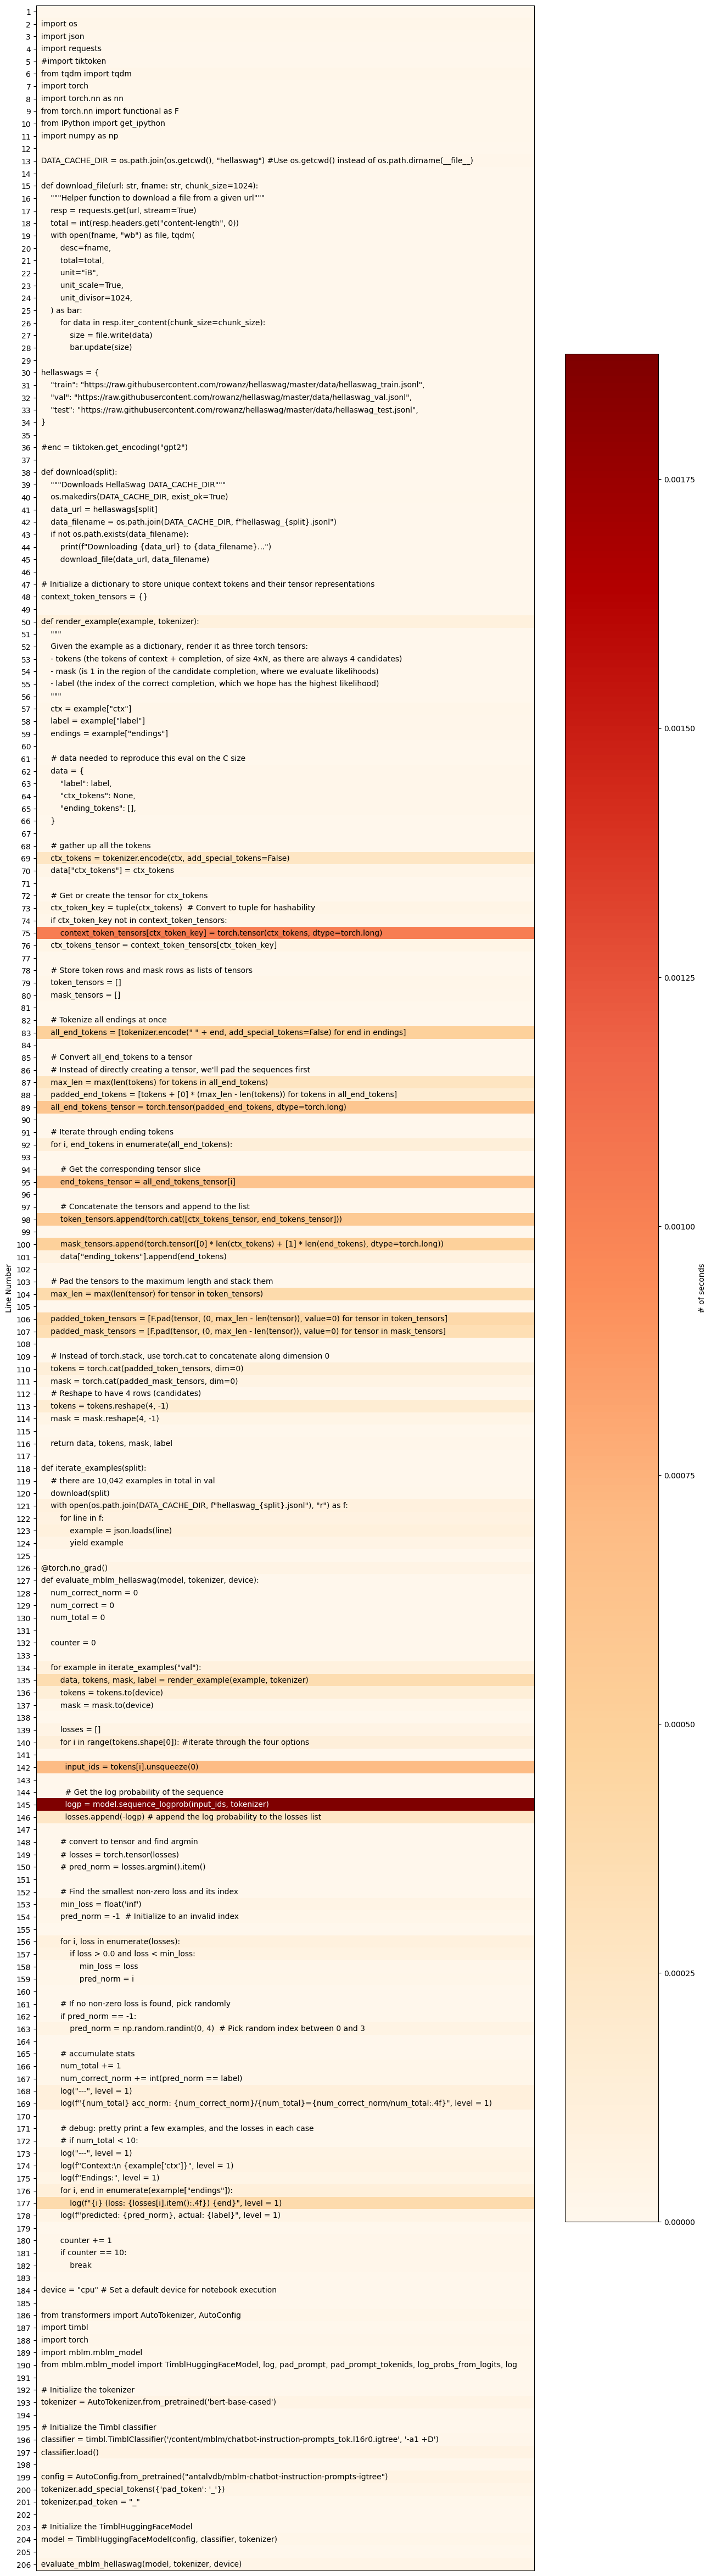

In [10]:
import os
import json
import requests
#import tiktoken
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.nn import functional as F
from IPython import get_ipython
import numpy as np

DATA_CACHE_DIR = os.path.join(os.getcwd(), "hellaswag") #Use os.getcwd() instead of os.path.dirname(__file__)

def download_file(url: str, fname: str, chunk_size=1024):
    """Helper function to download a file from a given url"""
    resp = requests.get(url, stream=True)
    total = int(resp.headers.get("content-length", 0))
    with open(fname, "wb") as file, tqdm(
        desc=fname,
        total=total,
        unit="iB",
        unit_scale=True,
        unit_divisor=1024,
    ) as bar:
        for data in resp.iter_content(chunk_size=chunk_size):
            size = file.write(data)
            bar.update(size)

hellaswags = {
    "train": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_train.jsonl",
    "val": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_val.jsonl",
    "test": "https://raw.githubusercontent.com/rowanz/hellaswag/master/data/hellaswag_test.jsonl",
}

#enc = tiktoken.get_encoding("gpt2")

def download(split):
    """Downloads HellaSwag DATA_CACHE_DIR"""
    os.makedirs(DATA_CACHE_DIR, exist_ok=True)
    data_url = hellaswags[split]
    data_filename = os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl")
    if not os.path.exists(data_filename):
        print(f"Downloading {data_url} to {data_filename}...")
        download_file(data_url, data_filename)

# Initialize a dictionary to store unique context tokens and their tensor representations
context_token_tensors = {}

def render_example(example, tokenizer):
    """
    Given the example as a dictionary, render it as three torch tensors:
    - tokens (the tokens of context + completion, of size 4xN, as there are always 4 candidates)
    - mask (is 1 in the region of the candidate completion, where we evaluate likelihoods)
    - label (the index of the correct completion, which we hope has the highest likelihood)
    """
    ctx = example["ctx"]
    label = example["label"]
    endings = example["endings"]

    # data needed to reproduce this eval on the C size
    data = {
        "label": label,
        "ctx_tokens": None,
        "ending_tokens": [],
    }

    # gather up all the tokens
    ctx_tokens = tokenizer.encode(ctx, add_special_tokens=False)
    data["ctx_tokens"] = ctx_tokens

    # Get or create the tensor for ctx_tokens
    ctx_token_key = tuple(ctx_tokens)  # Convert to tuple for hashability
    if ctx_token_key not in context_token_tensors:
        context_token_tensors[ctx_token_key] = torch.tensor(ctx_tokens, dtype=torch.long)
    ctx_tokens_tensor = context_token_tensors[ctx_token_key]

    # Store token rows and mask rows as lists of tensors
    token_tensors = []
    mask_tensors = []

    # Tokenize all endings at once
    all_end_tokens = [tokenizer.encode(" " + end, add_special_tokens=False) for end in endings]

    # Convert all_end_tokens to a tensor
    # Instead of directly creating a tensor, we'll pad the sequences first
    max_len = max(len(tokens) for tokens in all_end_tokens)
    padded_end_tokens = [tokens + [0] * (max_len - len(tokens)) for tokens in all_end_tokens]
    all_end_tokens_tensor = torch.tensor(padded_end_tokens, dtype=torch.long)

    # Iterate through ending tokens
    for i, end_tokens in enumerate(all_end_tokens):

        # Get the corresponding tensor slice
        end_tokens_tensor = all_end_tokens_tensor[i]

        # Concatenate the tensors and append to the list
        token_tensors.append(torch.cat([ctx_tokens_tensor, end_tokens_tensor]))

        mask_tensors.append(torch.tensor([0] * len(ctx_tokens) + [1] * len(end_tokens), dtype=torch.long))
        data["ending_tokens"].append(end_tokens)

    # Pad the tensors to the maximum length and stack them
    max_len = max(len(tensor) for tensor in token_tensors)

    padded_token_tensors = [F.pad(tensor, (0, max_len - len(tensor)), value=0) for tensor in token_tensors]
    padded_mask_tensors = [F.pad(tensor, (0, max_len - len(tensor)), value=0) for tensor in mask_tensors]

    # Instead of torch.stack, use torch.cat to concatenate along dimension 0
    tokens = torch.cat(padded_token_tensors, dim=0)
    mask = torch.cat(padded_mask_tensors, dim=0)
    # Reshape to have 4 rows (candidates)
    tokens = tokens.reshape(4, -1)
    mask = mask.reshape(4, -1)

    return data, tokens, mask, label

def iterate_examples(split):
    # there are 10,042 examples in total in val
    download(split)
    with open(os.path.join(DATA_CACHE_DIR, f"hellaswag_{split}.jsonl"), "r") as f:
        for line in f:
            example = json.loads(line)
            yield example

@torch.no_grad()
def evaluate_mblm_hellaswag(model, tokenizer, device):
    num_correct_norm = 0
    num_correct = 0
    num_total = 0

    counter = 0

    for example in iterate_examples("val"):
        data, tokens, mask, label = render_example(example, tokenizer)
        tokens = tokens.to(device)
        mask = mask.to(device)

        losses = []
        for i in range(tokens.shape[0]): #iterate through the four options

          input_ids = tokens[i].unsqueeze(0)

          # Get the log probability of the sequence
          logp = model.sequence_logprob(input_ids, tokenizer)
          losses.append(-logp) # append the log probability to the losses list

        # convert to tensor and find argmin
        # losses = torch.tensor(losses)
        # pred_norm = losses.argmin().item()

        # Find the smallest non-zero loss and its index
        min_loss = float('inf')
        pred_norm = -1  # Initialize to an invalid index

        for i, loss in enumerate(losses):
            if loss > 0.0 and loss < min_loss:
                min_loss = loss
                pred_norm = i

        # If no non-zero loss is found, pick randomly
        if pred_norm == -1:
            pred_norm = np.random.randint(0, 4)  # Pick random index between 0 and 3

        # accumulate stats
        num_total += 1
        num_correct_norm += int(pred_norm == label)
        log("---", level = 1)
        log(f"{num_total} acc_norm: {num_correct_norm}/{num_total}={num_correct_norm/num_total:.4f}", level = 1)

        # debug: pretty print a few examples, and the losses in each case
        # if num_total < 10:
        log("---", level = 1)
        log(f"Context:\n {example['ctx']}", level = 1)
        log(f"Endings:", level = 1)
        for i, end in enumerate(example["endings"]):
            log(f"{i} (loss: {losses[i].item():.4f}) {end}", level = 1)
        log(f"predicted: {pred_norm}, actual: {label}", level = 1)

        counter += 1
        if counter == 10:
            break

device = "cpu" # Set a default device for notebook execution

from transformers import AutoTokenizer, AutoConfig
import timbl
import torch
import mblm.mblm_model
from mblm.mblm_model import TimblHuggingFaceModel, log, pad_prompt, pad_prompt_tokenids, log_probs_from_logits, log

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Initialize the Timbl classifier
classifier = timbl.TimblClassifier('/content/mblm/chatbot-instruction-prompts_tok.l16r0.igtree', '-a1 +D')
classifier.load()

config = AutoConfig.from_pretrained("antalvdb/mblm-chatbot-instruction-prompts-igtree")
tokenizer.add_special_tokens({'pad_token': '_'})
tokenizer.pad_token = "_"

# Initialize the TimblHuggingFaceModel
model = TimblHuggingFaceModel(config, classifier, tokenizer)

evaluate_mblm_hellaswag(model, tokenizer, device)

In [26]:
device = "cpu" # Set a default device for notebook execution

from transformers import AutoTokenizer, AutoConfig
import timbl
import torch
import mblm.mblm_model
from mblm.mblm_model import TimblHuggingFaceModel, log, pad_prompt, pad_prompt_tokenids, log_probs_from_logits, log

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Initialize the Timbl classifier
classifier = timbl.TimblClassifier('/content/mblm/chatbot-instruction-prompts_tok.l16r0.igtree', '-a1 +D')
classifier.load()

config = AutoConfig.from_pretrained("antalvdb/mblm-chatbot-instruction-prompts-igtree")
tokenizer.add_special_tokens({'pad_token': '_'})
tokenizer.pad_token = "_"

# Initialize the TimblHuggingFaceModel
model = TimblHuggingFaceModel(config, classifier, tokenizer)

evaluate_mblm_hellaswag(model, tokenizer, device)

Calling Timbl API : -F Tabbed -a1 +D


TypeError: 'bool' object is not iterable

### TriviaQA

This is based on a [Colab Notebook](https://colab.research.google.com/github/patrickvonplaten/notebooks/blob/master/Evaluating_Big_Bird_on_TriviaQA.ipynb) by Patrick van Platen. This part of the notebook does not work yet and is very much work in progres

In [ ]:
import datasets

validation_dataset = datasets.load_dataset("trivia_qa", "rc", split="validation[:5%]")  # remove [:5%] to run on full validation set

In [ ]:
validation_dataset

In [ ]:
validation_dataset.info.features

In [ ]:
def format_dataset(example):
    # the context might be comprised of multiple contexts => me merge them here
    example["context"] = " ".join(("\n".join(example["entity_pages"]["wiki_context"])).split("\n"))
    example["targets"] = example["answer"]["aliases"]
    example["norm_target"] = example["answer"]["normalized_value"]
    return example

In [ ]:
validation_dataset = validation_dataset.map(format_dataset, remove_columns=["search_results", "question_source", "entity_pages", "answer", "question_id"])

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(validation_dataset, num_examples=3)

In [ ]:
validation_dataset = validation_dataset.filter(lambda x: len(x["context"]) > 0)
# check out how many samples are left
validation_dataset

In [ ]:
short_validation_dataset = validation_dataset.filter(lambda x: (len(x['question']) + len(x['context'])) < 4 * 4096)
short_validation_dataset

In [ ]:
PUNCTUATION_SET_TO_EXCLUDE = set(''.join(['‘', '’', '´', '`', '.', ',', '-', '"']))

def get_sub_answers(answers, begin=0, end=None):
  return [" ".join(x.split(" ")[begin:end]) for x in answers if len(x.split(" ")) > 1]

def expand_to_aliases(given_answers, make_sub_answers=False):
  if make_sub_answers:
    # if answers are longer than one word, make sure a predictions is correct if it coresponds to the complete 1: or :-1 sub word
    # *e.g.* if the correct answer contains a prefix such as "the", or "a"
    given_answers = given_answers + get_sub_answers(given_answers, begin=1) + get_sub_answers(given_answers, end=-1)
  answers = []
  for answer in given_answers:
    alias = answer.replace('_', ' ').lower()
    alias = ''.join(c if c not in PUNCTUATION_SET_TO_EXCLUDE else ' ' for c in alias)
    answers.append(' '.join(alias.split()).strip())
  return set(answers)

In [ ]:
def get_best_valid_start_end_idx(start_scores, end_scores, top_k=1, max_size=100):
    best_start_scores, best_start_idx = torch.topk(start_scores, top_k)
    best_end_scores, best_end_idx = torch.topk(end_scores, top_k)

    widths = best_end_idx[:, None] - best_start_idx[None, :]
    mask = torch.logical_or(widths < 0, widths > max_size)
    scores = (best_end_scores[:, None] + best_start_scores[None, :]) - (1e8 * mask)
    best_score = torch.argmax(scores).item()

    return best_start_idx[best_score % top_k], best_end_idx[best_score // top_k]

In [ ]:
def evaluate_mblm_triviaqa(example):
    # encode question and context so that they are seperated by a tokenizer.sep_token and cut at max_length
    encoding = tokenizer(example["question"], example["context"], return_tensors="pt", max_length=4096, padding="max_length", truncation=True)
    input_ids = encoding.input_ids.to("cpu")

    with torch.no_grad():
        start_scores, end_scores = model(input_ids=input_ids).to_tuple()

    start_score, end_score = get_best_valid_start_end_idx(start_scores[0], end_scores[0], top_k=8, max_size=16)

    # Let's convert the input ids back to actual tokens
    all_tokens = tokenizer.convert_ids_to_tokens(encoding["input_ids"][0].tolist())
    answer_tokens = all_tokens[start_score: end_score + 1]

    example["output"] = tokenizer.decode(tokenizer.convert_tokens_to_ids(answer_tokens))
    #.replace('"', '')  # remove space prepending space token and remove unnecessary '"'

    answers = expand_to_aliases(example["targets"], make_sub_answers=True)
    predictions = expand_to_aliases([example["output"]])

    # if there is a common element, it's a match
    example["match"] = len(list(answers & predictions)) > 0

    return example


In [ ]:
device = "cpu" # Set a default device for notebook execution

from transformers import AutoTokenizer, AutoConfig
import timbl
import torch
import mblm.mblm_model
from mblm.mblm_model import TimblHuggingFaceModel, log, pad_prompt, pad_prompt_tokenids, log_probs_from_logits
from mblm.mblm_model import log

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Initialize the Timbl classifier
classifier = timbl.TimblClassifier('/content/mblm/chatbot-instruction-prompts_tok.l16r0.igtree', '-a1 +D')
classifier.load()

config = AutoConfig.from_pretrained("antalvdb/mblm-chatbot-instruction-prompts-igtree")
tokenizer.add_special_tokens({'pad_token': '_'})
tokenizer.pad_token = "_"

# Initialize the TimblHuggingFaceModel
model = TimblHuggingFaceModel(config, classifier, tokenizer)

results_short = short_validation_dataset.map(evaluate_mblm_triviaqa)